In [1]:
import _pickle as pickle
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os
import seaborn as sns
import pandas as pd
import timeit

from itertools import product
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

from utils import set_size, pgf_with_latex

In [2]:
plt.style.use("seaborn-v0_8-colorblind")

# Using the set_size function as defined earlier
doc_width_pt = 452.9679

In [3]:
stats_keys = [
    "accuracy",
    "p_iwl",
    "context contains query class",
    "loss",
    "ic_pred",
    "iw_pred",
]

In [4]:
repo_path = "/Users/chanb/research/ualberta/icl/simple_icl"
results_dir = "/Users/chanb/research/ualberta/icl/cc_results/paper_experiments/evaluation_results"
results_dir = "/Users/chanb/research/ualberta/icl/cc_results/paper_experiments/rebuttal/evaluation_results"

# repo_path = "/home/bryanpu1/projects/icl/simple_icl"
# results_dir = "/home/bryanpu1/projects/icl/scratch/evaluation_results"
# results_dir = "/home/bryanpu1/projects/icl/cc_results/evaluation_results"

if repo_path.startswith("/Users"):
    plt.rcParams.update(pgf_with_latex)

In [17]:
variant_name = "synthetic-transformer-noisy_inputs"
# variant_name = "synthetic-gru-noisy_inputs"
variant_name = "omniglot-input_noise"

# Post submission
# variant_name = "synthetic-transformer-4_tf_blocks-noisy_inputs"

if "_tf_blocks" in variant_name:
    dataset_scale = np.log2
    checkpoint_steps = 1000
    dataset_unit = "(in $\\log_{2}$)"
    num_seeds = 5
    chance_error = 499/500
elif variant_name.startswith("synthetic"):
    dataset_scale = np.log2
    checkpoint_steps = 1000
    dataset_unit = "(in $\\log_{2}$)"
    num_seeds = 5
    chance_error = 9/10
else:
    # dataset_scale = np.log10
    # checkpoint_steps = 2500
    # dataset_unit = "(in $\\log_{10}$)"
    dataset_scale = np.log2
    checkpoint_steps = 2500
    dataset_unit = "(in $\\log_{2}$)"
    num_seeds = 3
    chance_error = 1622/1623

stats_file = os.path.join(repo_path, "plot_utils/plots/agg_stats", "{}.feather".format(variant_name))
stats = pd.read_feather(stats_file)

os.makedirs(
    os.path.join(repo_path, "plot_utils/plots/acc-plots", variant_name),
    exist_ok=True
)

results_dir = os.path.join(results_dir, variant_name)
plot_names = [
    "pretraining",
    "context-default",
    "iwl",
    "iwl-flip_label",
    "icl-last_context",
    "icl-last_context-flip_label",
    "icl-except_first_context",
    "icl-except_first_context-flip_label",
]
plot_titles = [
    "Pretraining",
    "Context Default"
    "In-weight Evaluation",
    "In-weight Evaluation with Flipped Label",
    "In-context Evaluation with Last Context",
    "In-context Evaluation with Last Context + Flipped Label",
    "In-context Evaluation with Contexts but First",
    "In-context Evaluation with Contexts but First + Flipped Label",
]

map_stats_key = {
    "p_iwl": "$\\alpha(x)$",
    "accuracy": "Accuracy",
    "context contains query class": "Context Contains Query Class",
    "loss": "Loss",
    "ic_pred": "In-context Accuracy",
    "iw_pred": "In-weight Accuracy"
}

map_variant = {
    "ground_truth_prob": "$P(g(x) = c)$",
    "high_prob": "$P(high\_freq.)$"
}

In [18]:
variants = stats["variant"].unique()

In [19]:
stats["eval_name"].unique()

array([None, 'eval-default-none-flip_label',
       'eval-default-high_prob-flip_label',
       'eval-default-low_prob-flip_label',
       'eval-relevant_context-none-flip_label',
       'eval-relevant_context-high_prob-flip_label',
       'eval-relevant_context-low_prob-flip_label',
       'eval-irrelevant_context-none-flip_label',
       'eval-irrelevant_context-high_prob-flip_label',
       'eval-irrelevant_context-low_prob-flip_label', 'eval-default-none',
       'eval-default-high_prob', 'eval-default-low_prob',
       'eval-relevant_context-none', 'eval-relevant_context-high_prob',
       'eval-relevant_context-low_prob', 'eval-irrelevant_context-none',
       'eval-irrelevant_context-high_prob',
       'eval-irrelevant_context-low_prob', 'pretraining'], dtype=object)

# Transformer

In [20]:
stats

,dirname,variant,seed,dataset_size,p_relevant_context,input_noise_std,batches,run_name,model_type,eval_name,stats_key,stats
0,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,1000000,0.9,0.0,"{'num_relevant_contexts': [[1, 1, 1, 1, 1, 1, ...",dataset_size_1000000-p_relevant_context_0.9-in...,None,None,None,None
1,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,1000000,0.9,0.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-default-none-flip_label,accuracy,"[0.0, 0.0, 0.0, 0.009, 0.036, 0.063, 0.084, 0...."
2,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,1000000,0.9,0.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-default-none-flip_label,context contains query class,"[0.892, 0.892, 0.892, 0.892, 0.892, 0.892, 0.8..."
3,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,1000000,0.9,0.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-default-none-flip_label,loss,"[7.857308387756348, 8.400153160095215, 9.46984..."
4,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,1000000,0.9,0.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-default-high_prob-flip_label,accuracy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4639,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,1000000,0.9,1.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-irrelevant_context-low_prob,context contains query class,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4640,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,1000000,0.9,1.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,eval-irrelevant_context-low_prob,loss,"[7.900698661804199, 8.157305717468262, 7.15407..."
4641,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,1000000,0.9,1.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,pretraining,accuracy,"[0.0001, 0.897, 0.9059, 0.9481, 0.9801, 0.9871..."
4642,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,1000000,0.9,1.0,None,dataset_size_1000000-p_relevant_context_0.9-in...,transformer,pretraining,context contains query class,"[0.8986, 0.8986, 0.8986, 0.8986, 0.8986, 0.898..."


In [21]:
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
input_noise_stds = sorted([float(input_noise_std) for input_noise_std in stats["input_noise_std"].unique()])
model_types = ["iw", "ic", "transformer"]

# Pretraining

### Loss

In [22]:
ls = {
    "iw": "--",
    "ic": "-.",
    "transformer": ":",
}

In [23]:
best_idxes = dict()

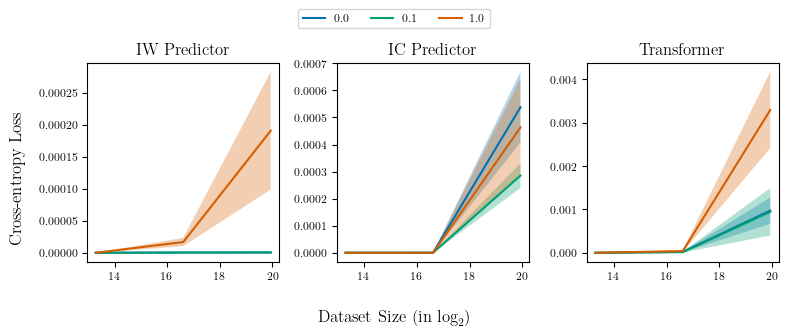

In [24]:
map_label = {
    "iw": "IW Predictor",
    "ic": "IC Predictor",
    "transformer": "GRU" if "gru" in variant_name else "Transformer",
}

p_relevant_context = 0.9

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for ax_i, model_type in enumerate(model_types):
    ax = axes[ax_i]
    for variant_i, input_noise_std in enumerate(input_noise_stds):
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "loss")
                & (stats["eval_name"] == "pretraining")
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = data.shape[1] - np.argmin(data[:, ::-1], axis=-1) - 1

            best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )] = best_idx

            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)

            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if ax_i == 0 else "")
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_title(map_label[model_type])
    # ax.set_ylim(0.0, 0.009)

fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size {}".format(dataset_unit))
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

### Accuracy

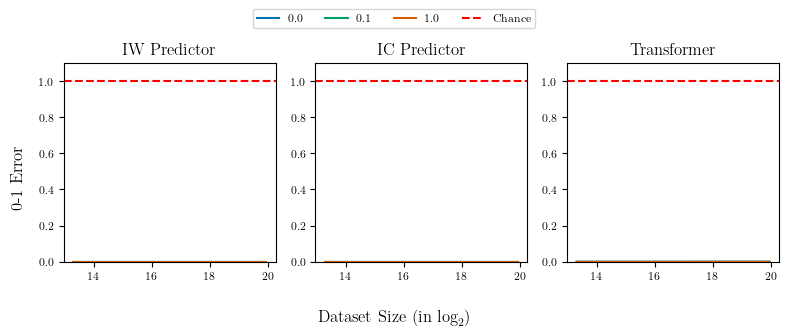

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for ax_i, model_type in enumerate(model_types):
    ax = axes[ax_i]
    for variant_i, input_noise_std in enumerate(input_noise_stds):
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == "pretraining")
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if ax_i == 0 else "")
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_title(map_label[model_type])
    ax.set_ylim(0.0, 1.1)
    ax.axhline(chance_error, label="Chance" if ax_i == 0 else "", c="red", linestyle="--")

fig.supylabel("0-1 Error")
fig.supxlabel("Dataset Size {}".format(dataset_unit))
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

## General Plots

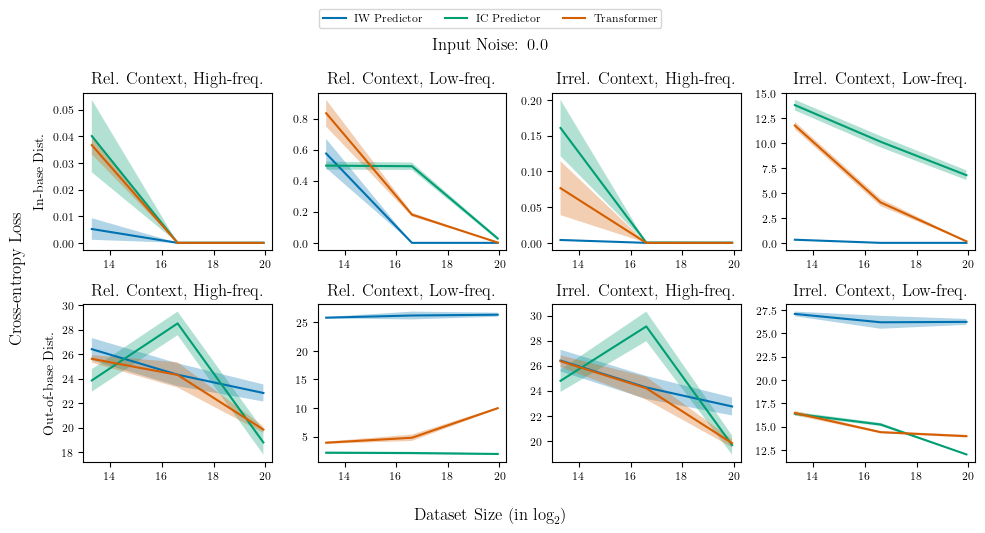

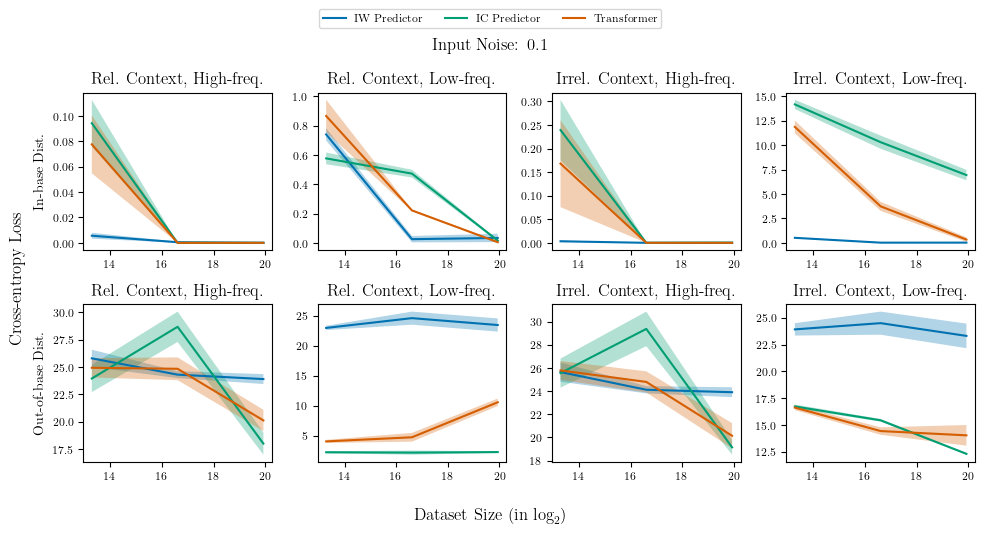

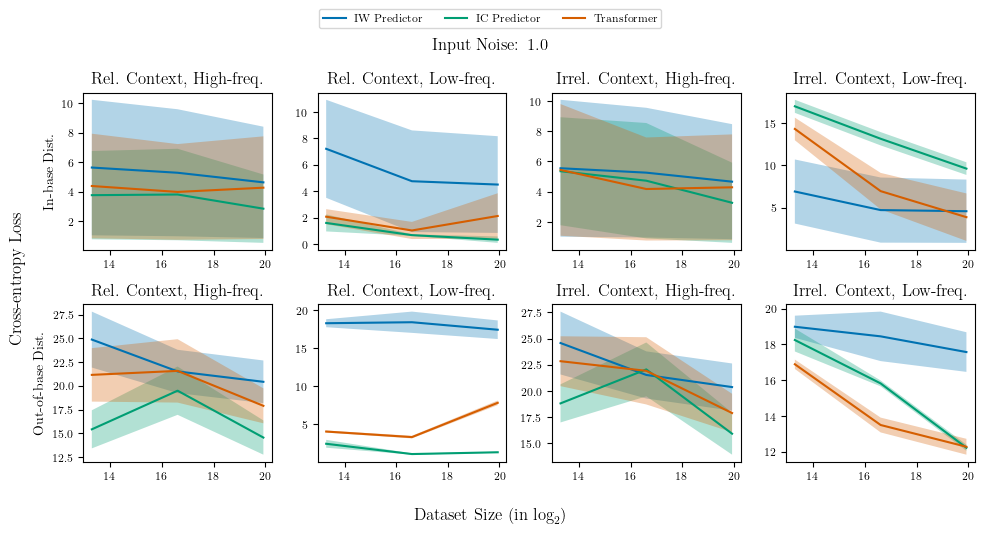

In [26]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            # ax.set_ylim(-1.0, 1.5)
            if eval_i == 0:
                ax.set_ylabel("In-base Dist." if row_i == 0 else "Out-of-base Dist.")

            # ax.set_ylim(-1.0, 1.0)
    fig.suptitle("Input Noise: {}".format(input_noise_std))
    fig.supylabel("Cross-entropy Loss")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

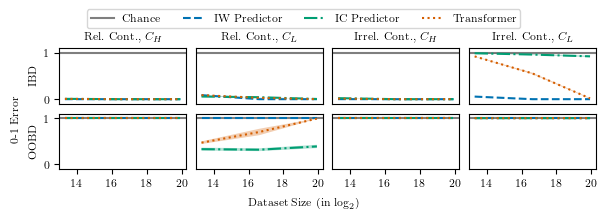

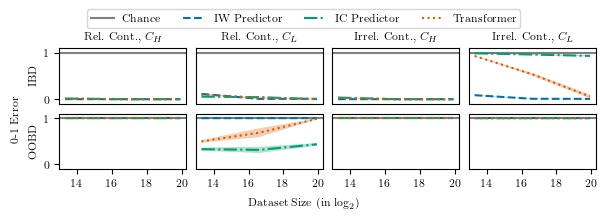

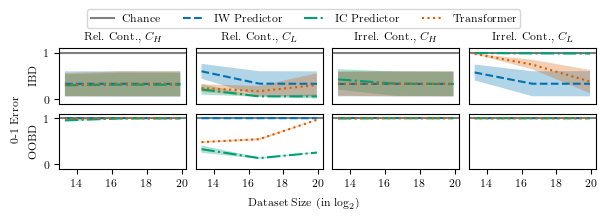

In [13]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob": "Irrel. Cont., $C_L$",
    "eval-relevant_context-high_prob-flip_label": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob-flip_label": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Cont., $C_L$",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

map_ls = {
    "iw": "--",
    "ic": "-.",
    "transformer": ":",
}
if variant_name.startswith("synthetic"):
    base = 4.0
else:
    base = 2.0

num_rows = 2
num_cols = 4

for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
        layout="constrained",
    )
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            ax.axhline(chance_error, label="Chance" if eval_i == 0 and row_i == 0 else "", c="black", linestyle="-", alpha=0.5)
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = 1 - (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "", linestyle=ls[model_type])
                ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_ylim(-0.1, 1.1)
            loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
            ax.xaxis.set_major_locator(loc)

            if eval_i == 0:
                ax.set_ylabel("IBD" if row_i == 0 else "OOBD", fontsize="8",)

            if eval_i > 0:
                ax.set_yticks([])

            if row_i == 0:
                ax.set_title(map_eval[eval_name], fontsize="8",)
                ax.set_xticks([])

    # fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
    fig.supylabel("0-1 Error", fontsize="8",)
    fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    # fig.tight_layout()
    plt.savefig("{}-noisy_inputs-input_noise_{}.pdf".format(variant_name, input_noise_std), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob": "Irrel. Cont., $C_L$",
    "eval-relevant_context-high_prob-flip_label": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob-flip_label": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Cont., $C_L$",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_namess = [
    [
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
    ],
]

map_ls = {
    "iw": "--",
    "ic": "-.",
    "transformer": ":",
}
if variant_name.startswith("synthetic"):
    base = 4.0
else:
    base = 2.0

num_rows = 2
num_cols = 2

for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
        layout="constrained",
    )
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            ax.axhline(chance_error, label="Chance" if eval_i == 0 and row_i == 0 else "", c="black", linestyle="-", alpha=0.5)
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = 1 - (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "", linestyle=ls[model_type])
                ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_ylim(-0.1, 1.1)
            loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
            ax.xaxis.set_major_locator(loc)

            if eval_i == 0:
                ax.set_ylabel("IWL" if row_i == 0 else "ICL", fontsize="8",)

            if eval_i > 0:
                ax.set_yticks([])

            if row_i == 0:
                ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
                ax.set_xticks([])

    # fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
    fig.supylabel("0-1 Error", fontsize="8",)
    fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    # fig.tight_layout()
    # plt.savefig("{}-noisy_inputs-input_noise_{}.pdf".format(variant_name, input_noise_std), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob": "Irrel. Cont., $C_L$",
    "eval-relevant_context-high_prob-flip_label": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob-flip_label": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Cont., $C_L$",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

map_ls = {
    "iw": "--",
    "ic": "-.",
    "transformer": ":",
}
if variant_name.startswith("synthetic"):
    base = 4.0
else:
    base = 1.0

num_rows = 2
num_cols = 4

for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
        layout="constrained",
    )
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            # ax.axhline(chance_error, label="Chance" if eval_i == 0 and row_i == 0 else "", c="black", linestyle="-", alpha=0.5)
            ax.axhline(0.0, label="Equal" if eval_i == 0 and row_i == 0 else "", c="black", linestyle="-", alpha=0.5)

            model_type_losses = {}
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = 1 - (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    # data = (np.array(stats[
                    #     (stats["p_relevant_context"] == f"{p_relevant_context}")
                    #     & (stats["input_noise_std"] == f"{input_noise_std}")
                    #     & (stats["stats_key"] == "loss")
                    #     & (stats["eval_name"] == eval_name)
                    #     & (stats["dataset_size"] == f"{dataset_size}")
                    #     & (stats["model_type"] == f"{model_type}")
                    # ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                model_type_losses[model_type] = losses_mean
                # ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "", linestyle=ls[model_type])
                # ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.plot(dataset_scale(np.array(dataset_sizes)), model_type_losses["iw"] - model_type_losses["ic"], label="" if eval_i == 0 and row_i == 0 else "", linestyle=ls[model_type])
            ax.set_ylim(-1.1, 1.1)
            loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
            ax.xaxis.set_major_locator(loc)

            if eval_i == 0:
                ax.set_ylabel("IBD" if row_i == 0 else "OOBD", fontsize="8",)

            if eval_i > 0:
                ax.set_yticks([])

            if row_i == 0:
                ax.set_title(map_eval[eval_name], fontsize="8",)
                ax.set_xticks([])

    # fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
    fig.supylabel("$\\varepsilon_{IW} - \\varepsilon_{IC}$", fontsize="8",)
    fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    # fig.tight_layout()
    # plt.savefig("{}-noisy_inputs-input_noise_{}.pdf".format(variant_name, input_noise_std), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
stats["eval_name"].unique()

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_names = [
    "eval-relevant_context-none",
    "eval-irrelevant_context-none",
    "eval-relevant_context-none-flip_label",
    "eval-irrelevant_context-none-flip_label",
]
for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[eval_i]
        for model_type in model_types:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 else "")
            ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="red", linestyle="--")
        ax.set_ylim(-0.1, 1.1)

    fig.suptitle("Input Noise: {}".format(input_noise_std))
    fig.supylabel("0-1 Error")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",

    "eval-default-high_prob": "$C_H$",
    "eval-default-low_prob": "$C_L$",
    "eval-default-high_prob-flip_label": "$C_H$, Flip",
    "eval-default-low_prob-flip_label": "$C_L$, Flip",
}

eval_names = [
    "eval-default-high_prob",
    "eval-default-low_prob",
    "eval-default-high_prob-flip_label",
    "eval-default-low_prob-flip_label",
]
for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[eval_i]
        for model_type in model_types:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 else "")
            ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="red", linestyle="--")
        ax.set_ylim(-0.1, 1.1)

    fig.suptitle("Input Noise: {}".format(input_noise_std))
    fig.supylabel("0-1 Error")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
    "eval-default-none": "IBD",
    "eval-default-none-flip_label": "OOBD",
}

eval_names = [
    "eval-default-none",
    "eval-default-none-flip_label",
]

map_ls = {
    "iw": "--",
    "ic": "-.",
    "transformer": ":",
}
if variant_name.startswith("synthetic"):
    base = 4.0
else:
    base = 1.0

num_rows = 2
num_cols = len(input_noise_stds)
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)
for col_i, input_noise_std in enumerate(input_noise_stds):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[eval_i, col_i]
        # ax = axes[eval_i]
        ax.axhline(chance_error, label="Chance" if eval_i == 0 and col_i == 0 else "", c="black", linestyle="-", alpha=0.5)
        for model_type in model_types:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and col_i == 0 else "", linestyle=map_ls[model_type])
            ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_ylim(-0.1, 1.1)
        loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name], fontsize="8")

        if col_i > 0:
            ax.set_yticks([])

        if eval_i == 0:
            ax.set_xticks([])
    
    axes[0, col_i].set_title(f"$\\sigma = {input_noise_std}$", fontsize="8")

# fig.suptitle("Input Noise")
fig.supylabel("0-1 Error", fontsize="8")
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# fig.tight_layout()
plt.show()
# plt.savefig("{}-noisy_inputs.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
assert 0

# Slice based on Input noise

In [ ]:
map_eval = {
    "eval-default-high_prob": "Rel. Cont., $C_H$",
    "eval-default-low_prob": "Rel. Cont., $C_L$",
    "eval-relevant_context-high_prob": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob": "Irrel. Cont., $C_L$",
    "eval-relevant_context-high_prob-flip_label": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob-flip_label": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Cont., $C_L$",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

num_rows = 2
num_cols = 4
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    # figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=False),
    # figsize=(10, 5),
    layout="constrained",
)

dataset_size = dataset_sizes[0]
print(dataset_size)
input_noise_stds = [0.0, 0.2 ,0.4]
for row_i, eval_names in enumerate(eval_namess):
    for col_i, eval_name in enumerate(eval_names):

        ax = axes[row_i, col_i]

        for model_type in model_types:
            losses_mean = []
            losses_std = []
            for input_noise_std in input_noise_stds:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(np.array(input_noise_stds) / 0.4, losses_mean, label=map_label[model_type] if row_i == 0 and col_i == 0 else "", marker="x", alpha=1.0 if model_type == "transformer" else 0.5)
            ax.fill_between(np.array(input_noise_stds) / 0.4, losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)
            ax.axhline(chance_error, label="Chance" if eval_i == 0 and col_i == 0 else "", c="black", linestyle="--", alpha=0.5)

        ax.set_ylim(-0.1, 1.1)

        if col_i == 0:
            ax.set_ylabel("IBD" if row_i == 0 else "OOBD", fontsize="8")
    
        if col_i > 0:
            ax.set_yticks([])

        if row_i == 0:
            ax.set_xticks([])
            ax.set_title(map_eval[eval_name], fontsize="8")

# fig.suptitle("Input Noise")
fig.supylabel("0-1 Error", fontsize="8")
fig.supxlabel("$\\sigma / 0.4$", fontsize="8")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# plt.savefig("{}-noisy_inputs-slice_by_sigma.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")


In [ ]:
axes.shape

In [ ]:
variant_name, input_noise_stds

In [ ]:
eval_names = [
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
    "eval-relevant_context-high_prob-flip_label",
    "eval-relevant_context-low_prob-flip_label",
]

num_rows = 2
num_cols = 4

if variant_name.startswith("synthetic"):
    map_ls = {
        0.0: "--",
        0.2: "-.",
        0.4: ":",
    }
    base = 4.0
else:
    map_ls = {
        0.0: "--",
        0.1: "-.",
        1.0: ":",
    }
    base = 1.0

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)

model_type = "transformer"
for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), eval_i % 2]
    # ax = axes[eval_i]
    ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if eval_i == 0 else "", linestyle=map_ls[input_noise_std])
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_ylim(-0.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IWL" if eval_i == 0 else "ICL", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])

eval_names = [
    "eval-default-high_prob",
    "eval-default-low_prob",
    "eval-default-high_prob",
    "eval-default-low_prob",
]

for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), 2 + eval_i % 2]
    
    # model_type = "iw" if "irrelevant_context" in eval_name else "ic"
    model_type = "iw" if eval_i < 2 else "ic"
    ax.axhline(chance_error, c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, linestyle=map_ls[input_noise_std])
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_ylim(-0.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IW Pred." if eval_i == 0 else "IC Pred.", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])



# fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
fig.supylabel("0-1 Error", fontsize="8",)
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# plt.savefig("{}-noisy_inputs-icl_analysis.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
eval_names = [
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
    "eval-relevant_context-high_prob-flip_label",
    "eval-relevant_context-low_prob-flip_label",
]

num_rows = 2
num_cols = 4

if variant_name.startswith("synthetic"):
    map_ls = {
        0.0: "--",
        0.2: "-.",
        0.4: ":",
    }
    base = 4.0
else:
    map_ls = {
        0.0: "--",
        0.1: "-.",
        1.0: ":",
    }
    base = 1.0

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)

model_type = "transformer"
for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), eval_i % 2]
    # ax = axes[eval_i]
    ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if eval_i == 0 else "", linestyle=map_ls[input_noise_std])
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_ylim(-0.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IWL" if eval_i == 0 else "ICL", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])

eval_names = [
    "eval-default-high_prob",
    "eval-default-low_prob",
    "eval-default-high_prob",
    "eval-default-low_prob",
]

for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), 2 + eval_i % 2]
    
    ax.axhline(0.0, c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue

        model_type_losses = dict()
        for model_type in ["ic", "iw"]:
            losses_mean = []
            losses_std = []
            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)
            model_type_losses[model_type] = [losses_mean, losses_std]

        # ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, linestyle=map_ls[input_noise_std])
        # ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)
        ax.plot(
            dataset_scale(np.array(dataset_sizes)),
            model_type_losses["iw"][0] - model_type_losses["ic"][0],
            linestyle=map_ls[input_noise_std],
        )

    ax.set_ylim(-1.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IW Pred." if eval_i == 0 else "IC Pred.", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])



# fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
fig.supylabel("0-1 Error", fontsize="8",)
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# plt.savefig("{}-noisy_inputs-icl_analysis.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
eval_names = [
    "eval-default-high_prob",
    "eval-default-low_prob",
    "eval-default-high_prob-flip_label",
    "eval-default-low_prob-flip_label",
]

num_rows = 2
num_cols = 2

if variant_name.startswith("synthetic"):
    map_ls = {
        0.0: "--",
        0.2: "-.",
        0.4: ":",
    }
    base = 4.0
else:
    map_ls = {
        0.0: "--",
        0.1: "-.",
        1.0: ":",
    }
    base = 1.0

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.475, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)

model_type = "transformer"
for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), eval_i % 2]
    # ax = axes[eval_i]
    ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if eval_i == 0 else "", linestyle=map_ls[input_noise_std])
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_ylim(-0.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IBD" if eval_i == 0 else "OOBD", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])

fig.supylabel("Transformer Error", fontsize="8",)
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)

plt.savefig("{}-noisy_inputs-icl_analysis-transformer.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")


fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.475, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)

eval_names = [
    "eval-default-high_prob",
    "eval-default-low_prob",
    "eval-default-high_prob",
    "eval-default-low_prob",
]

for eval_i, eval_name in enumerate(eval_names):
    ax = axes[int(eval_i >= 2), eval_i % 2]
    
    # model_type = "iw" if "irrelevant_context" in eval_name else "ic"
    model_type = "iw" if eval_i < 2 else "ic"
    ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="black", linestyle="-", alpha=0.5)
    for input_noise_std in input_noise_stds:
        if input_noise_std == 0.02:
            continue
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, linestyle=map_ls[input_noise_std], label=input_noise_std if eval_i == 0 else "")
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_ylim(-0.1, 1.1)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if eval_i % 2 == 0:
        ax.set_ylabel("IW Pred." if eval_i == 0 else "IC Pred.", fontsize="8",)

    if eval_i % 2 != 0:
        ax.set_yticks([])

    if eval_i < 2:
        ax.set_title("$C_H$" if eval_i == 0 else "$C_L$", fontsize="8",)
        ax.set_xticks([])



# fig.suptitle("$\\sigma$ = {}".format(input_noise_std))
fig.supylabel("IC/IW Predictor IBD Error", fontsize="8",)
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8",)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
plt.savefig("{}-noisy_inputs-icl_analysis-pretraining_ic_iw.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")

In [ ]:
assert 0

# Gradient Steps

In [ ]:
row = stats[stats["batches"].notnull()]

In [ ]:
row

In [ ]:
dataset_sizes = [10000, 100000, 1000000]
dataset_size = 1000000
input_noise_std = 0.0
seeds = ["seed_0", "seed_1", "seed_2"]
num_high_prob_classes = 20
num_low_prob_classes = 1603

In [ ]:
unique_res = dict()

In [ ]:
# train_info_idx = 812
# train_info = row["batches"][train_info_idx]
for seed in seeds:
    train_info = row[
        (row["dataset_size"] == "{}".format(dataset_size))
        & (row["input_noise_std"] == "{}".format(input_noise_std))
        & (row["seed"] == seed)
    ]
    targets = np.array([list(curr_it_targ) for curr_it_targ in train_info["batches"].iloc[0]["targets"]])
    counts = np.cumsum(np.sum(targets > num_high_prob_classes, axis=-1))

    num_uniques = []
    it_unique_mask = np.zeros(num_low_prob_classes + num_high_prob_classes)
    for epoch_i in range(len(targets)):
    # for epoch_i in range(10):
        curr_unique, curr_counts = np.unique(targets[epoch_i], return_counts=True)
        it_unique_mask[curr_unique] = it_unique_mask[curr_unique] + curr_counts
        if (epoch_i + 1) % checkpoint_steps == 0:
            num_uniques.append(copy.deepcopy(it_unique_mask))

    unique_res[train_info["run_name"].iloc[0]] = num_uniques

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Cont., $C_H$",
    "eval-relevant_context-low_prob": "Rel. Cont., $C_L$",
    "eval-irrelevant_context-high_prob": "Irrel. Cont., $C_H$",
    "eval-irrelevant_context-low_prob": "Irrel. Cont., $C_L$",
    "eval-relevant_context-high_prob-flip_label": "Rel. Cont., $C_H$ OOBD",
    "eval-relevant_context-low_prob-flip_label": "Rel. Cont., $C_L$ OOBD",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Cont., $C_H$ OOBD",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Cont., $C_L$ OOBD",
    "pretraining": "Pretraining"
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

c_map = {
    "eval-relevant_context-high_prob": "blue",
    "eval-relevant_context-low_prob": "red",
    "eval-irrelevant_context-high_prob": "blue",
    "eval-irrelevant_context-low_prob": "red",
    "eval-relevant_context-high_prob-flip_label": "blue",
    "eval-relevant_context-low_prob-flip_label": "red",
    "eval-irrelevant_context-high_prob-flip_label": "blue",
    "eval-irrelevant_context-low_prob-flip_label": "red",
    "pretraining": "gray",
}
ls_map = {
    "eval-relevant_context-high_prob": ":",
    "eval-relevant_context-low_prob": ":",
    "eval-irrelevant_context-high_prob": ":",
    "eval-irrelevant_context-low_prob": ":",
    "eval-relevant_context-high_prob-flip_label": "-.",
    "eval-relevant_context-low_prob-flip_label": "-.",
    "eval-irrelevant_context-high_prob-flip_label": "-.",
    "eval-irrelevant_context-low_prob-flip_label": "-.",
    "pretraining": "-",
}


num_rows = 1
num_cols = 3
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    # figsize=set_size(doc_width_pt, 0.65, (num_rows, num_cols), use_golden_ratio=True),
    # figsize=(10, 5),
    layout="constrained",
)

plots = dict()

for ax_i, key in enumerate(unique_res):
    ax = axes[ax_i]
    for eval_name in [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "pretraining",
    ]:
        res = 1 - np.array(stats[
            (stats["run_name"] == key)
            & (stats["model_type"] == "transformer")
            & (stats["stats_key"] == "accuracy")
            & (stats["eval_name"] == eval_name)
        ]["stats"].tolist())[0, :-1]

        plots[eval_name], = ax.plot(
            np.arange(len(res)) * checkpoint_steps,
            res,
            label=map_eval[eval_name],
            color=c_map[eval_name],
            linestyle=ls_map[eval_name]
        )
    if ax_i > 0:
        ax.set_yticks([])

fig.supylabel("0-1 Error", fontsize="8")
# fig.supxlabel("Gradient Step", fontsize="8")

fake_bd, = ax.plot([], [], color = 'blue', linewidth = 1, label = 'my line', dashes=[9, 9], gapcolor='red')
fake_ibd, = ax.plot([], [], color = 'gray', linewidth = 1, label = 'my line', linestyle=":")
fake_oobd, = ax.plot([], [], color = 'gray', linewidth = 1, label = 'my line', linestyle="-.")
l = fig.legend(
    [
        (fake_bd,),
        (fake_ibd,),
        (fake_oobd,),
        (plots["pretraining"],)
    ],
    [
        "$C_H$/$C_L$",
        "IBD",
        "OOBD",
        "Pretraining"
    ],
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)

plt.savefig("{}-noisy_inputs-grad_steps.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")
# plt.close(fig)

In [ ]:

num_rows = 1
num_cols = 3
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    # figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    # figsize=(10, 5),
    layout="constrained",
)

for ax_i, key in enumerate(unique_res):
    ax = axes[ax_i]
    unique_i = unique_res[key]
    means = np.array([np.mean(curr_unique[num_high_prob_classes:]) for checkpoint_i, curr_unique in enumerate(unique_i)])
    medians = np.array([np.median(curr_unique[num_high_prob_classes:]) for checkpoint_i, curr_unique in enumerate(unique_i)])
    maxes = np.array([np.max(curr_unique[num_high_prob_classes:]) for checkpoint_i, curr_unique in enumerate(unique_i)])
    mins = np.array([np.min(curr_unique[num_high_prob_classes:]) for checkpoint_i, curr_unique in enumerate(unique_i)])


    ax.plot(
        np.arange(len(res)) * checkpoint_steps,
        means,
        linestyle="--",
        color="blue",
        label="Mean" if ax_i == 0 else ""
    )
    ax.plot(
        np.arange(len(res)) * checkpoint_steps,
        medians,
        color="red",
        label="Median" if ax_i == 0 else ""
    )

    ax.fill_between(
        np.arange(len(res)) * checkpoint_steps,
        maxes,
        mins,
        color="blue",
        alpha=0.3
    )

    ax.set_ylim(0,300)

    if ax_i > 0:
        ax.set_yticks([])
fig.supylabel("Total Occurrence", fontsize="8")
fig.supxlabel("Gradient Step", fontsize="8")
plt.savefig("{}-noisy_inputs-low_freq_occ.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# plt.close(fig)

In [ ]:
for ax_i, key in enumerate(unique_res):
    unique_i = unique_res[key]
    means = np.array([np.mean(curr_unique[num_high_prob_classes:]) for checkpoint_i, curr_unique in enumerate(unique_i)])
    print(means)